In [1]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
import torch
import os
import copy

from torchvision.ops import box_convert

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
def denormalize2(H, coords):
    """Convert coordinates in the range [-1, 1] to
    coordinates in the range [0, H] where `H` is
    the size of the image.
    """
    return (0.5 * ((coords + 1.0) * H)).long()

def load_data(config, test, epoch, name='test'):
    model_name = config['model_name']
    plot_dir = config['plot_dir']
    g = config['g']

    output_npz_file = f'{name}.npz' if test else f'val_{epoch}.npz'
    saved_data = dict(np.load(os.path.join(
        plot_dir, model_name, output_npz_file)))

    glimpses = saved_data['imgs']
    locations = saved_data['locs']
    if config['use_memory']:
        attention = saved_data['attn']
    else:
        attention = None
    output = saved_data['out']

    if glimpses.shape[1] == 1:  # remove single channel dim, MNIST
        glimpses = np.squeeze(glimpses, axis=1)

    num_anims = locations.shape[1]
    num_cols = glimpses.shape[0]
    img_shape = glimpses.shape[2]

     # m = (-1, 1)
    # ls = denormalize(torch.Tensor(locations), m, (0, img_shape))
    # wh = torch.tensor([g]).repeat(num_cols, 2)
    ls = denormalize2(img_shape, torch.Tensor(
        locations)).transpose(0, 1) - g//2
    wh = torch.tensor([g]).repeat(
        num_cols, 2).unsqueeze(0).repeat(num_anims, 1, 1)
    boxes_per_anim = torch.cat([ls, wh], dim=2).numpy()

    # boxes_per_anim = []
    # for i in range(num_anims):
    #     box = torch.hstack([ls[:, i], wh]).numpy()
    #     # box = box_convert(  # note: out_fmt differs from retina code
    #     #     boxes, in_fmt='cxcywh', out_fmt='xywh').numpy()
    #     boxes_per_anim.append(box)
    # boxes_per_anim = np.array(boxes_per_anim)
    # print(ls[0], boxes_per_anim[0])

    return glimpses, boxes_per_anim, ls, attention, output

In [20]:
# make plots of digits 3, 4, 5

config_path = '../configs/best/mnist/ours_029.yaml'

with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

test = True
epoch = 1
class_index = -1
g = config['g']

model_name = config['model_name']
plot_dir = config['plot_dir']

glimpses, boxes_per_anim, ls, attention, output = load_data(
    config, test, epoch, 'test')

# sort by class label
if class_index >= 0:
    inds = np.where(output[:, 0] == class_index)[0]
else:
    inds = np.argsort(output[:, 0])
ls = ls[:, inds].numpy() # top left corner of each glimpse
glimpses = glimpses[inds]
boxes_per_anim = boxes_per_anim[:, inds]
output = output[inds]

nrows, ncols = glimpses.shape[0], boxes_per_anim.shape[0]

additional = 0
if config['use_memory']:
    attention = attention[inds]
    additional = attention.shape[1]
    if additional > 1:
        additional += 1
    vmin, vmax = attention.min(), attention.max()

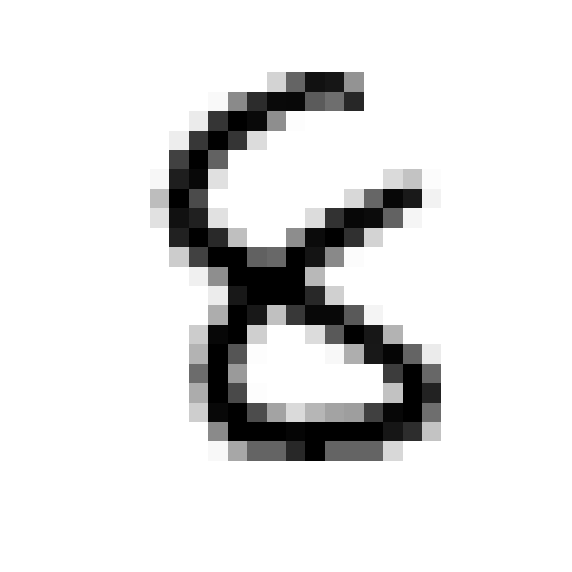

In [33]:
i = 8
fig, ax = plt.subplots(1,1,figsize=(5, 5))
ax.imshow(glimpses[i], cmap='gray_r')
ax.axis('off')
# ax.set_xticks([])
# ax.set_yticks([])
# for axis in ['top', 'bottom', 'left', 'right']:
#     ax.spines[axis].set_linewidth(5)  # change width
filename = os.path.join(plot_dir, model_name, f'mnist_digit_{i}.pdf')
plt.savefig(filename, dpi=300, bbox_inches='tight')

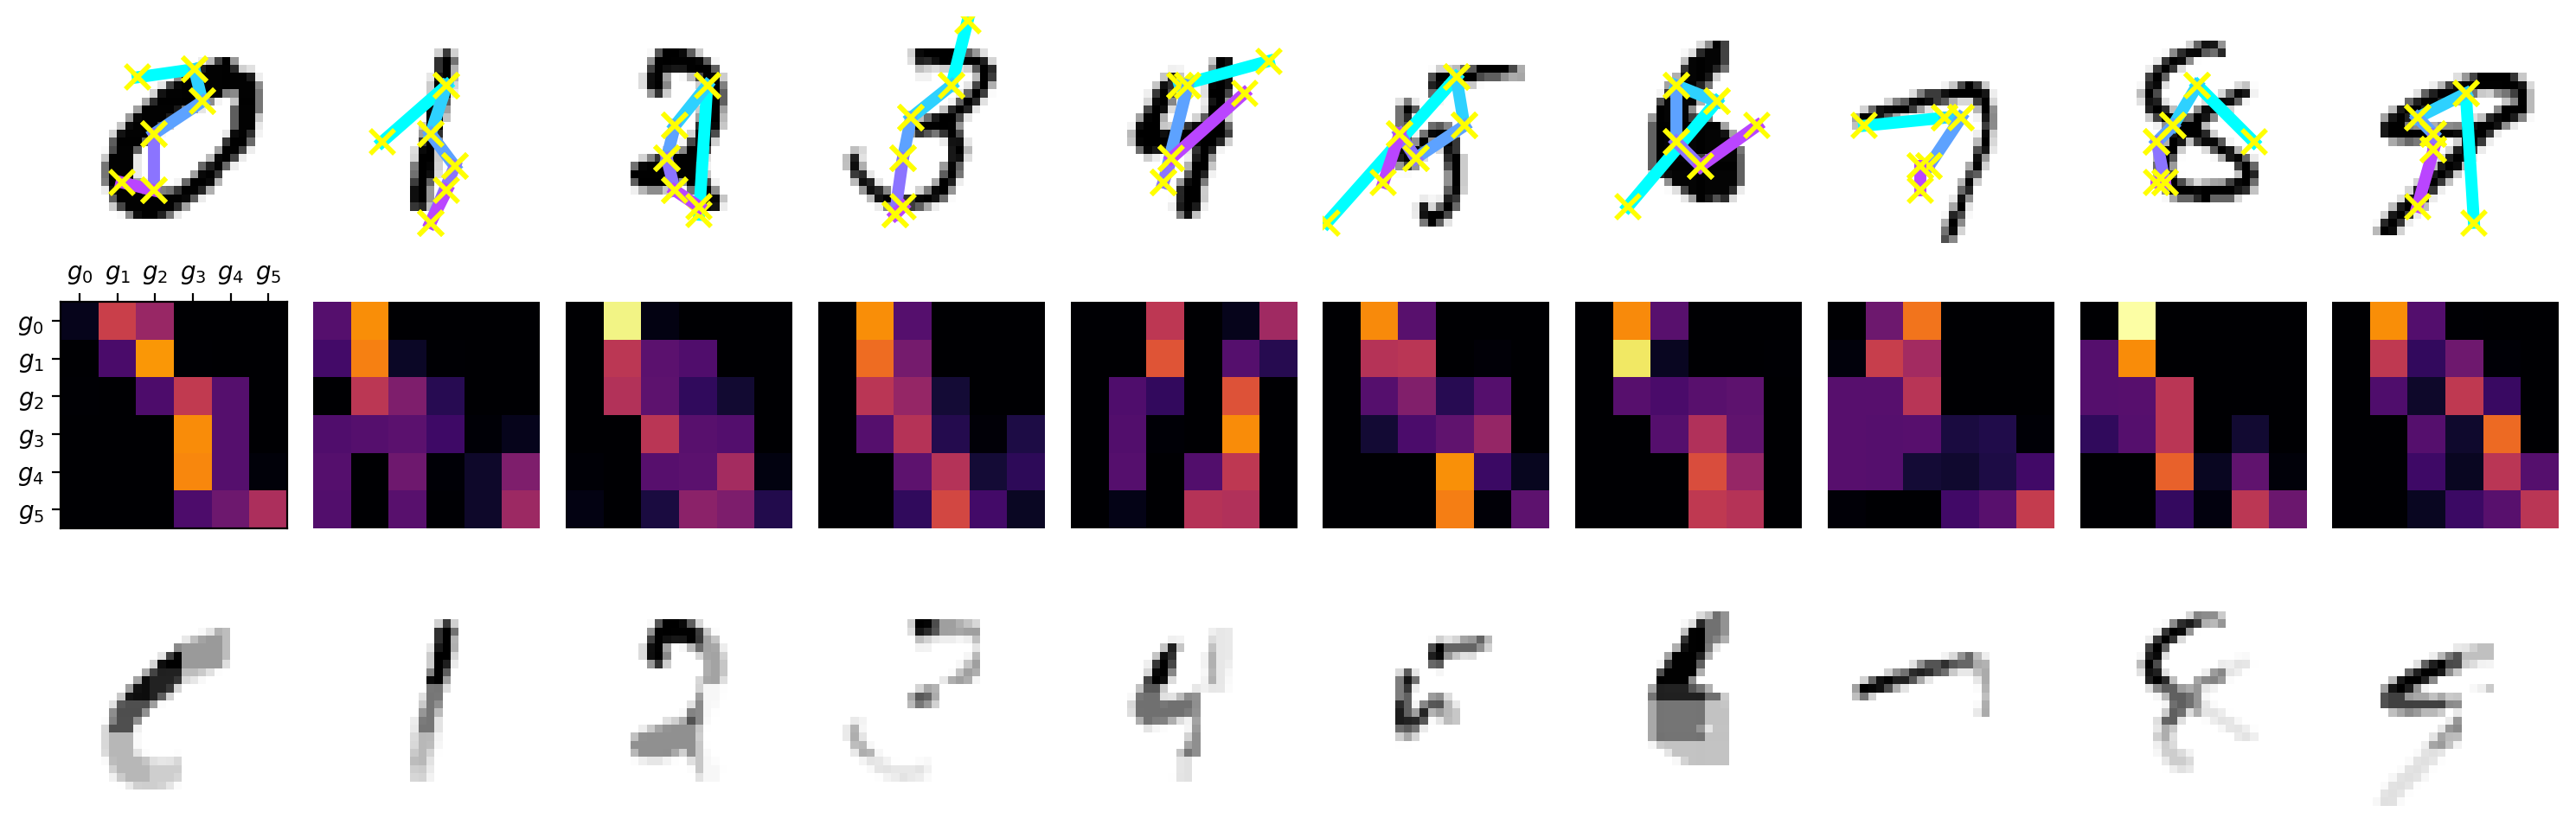

In [8]:
filename = os.path.join(plot_dir, model_name, 'mnist_importance3.pdf') # pdf

fig, axs = plt.subplots(3,10, figsize=(15,5))

for i,c in enumerate(range(10)):
    glimpse = glimpses[c]
    ax = axs[0,i]
    ax.imshow(glimpse, cmap='gray_r')

    cmap=plt.cm.cool
    xy = ls[:,c] + g // 2 # centered on each glimpse

    color = [cmap(i*2) for i in np.linspace(0, 1, xy.size)]
    for j, (start, stop) in enumerate(zip(xy[:-1], xy[1:])):
        x, y = zip(start, stop)
        ax.plot(x, y, 'x-', color=color[j],
                linewidth=5., markersize=10, mew=2, mec='yellow')
    ax.axis('off')

    ax = axs[1,i]
    mean_attn = np.mean(attention[c], axis=0)
    ax.imshow(mean_attn, cmap='inferno',vmin=0, vmax=1)
    if i == 0:
        lables = [f'$g_{i}$' for i in range(mean_attn.shape[0])]
        ax.set_xticks(list(range(mean_attn.shape[0])), minor=False)
        ax.xaxis.tick_top()
        ax.set_xticklabels(lables, minor=False)
        ax.set_yticks(list(range(mean_attn.shape[0])), minor=False)
        ax.set_yticklabels(lables, minor=False)
    else:
        ax.axis('off')

    ax = axs[2,i]
    H = glimpse.shape[-1]
    filler = np.zeros(glimpse.shape)
    attn_col_sum = mean_attn.sum(0)
    for k, l in enumerate(ls[:,c]):
        patch = copy.copy(glimpse[min(0,l[1]):l[1]+g,min(0,l[0]):l[0]+g])
        patch *= attn_col_sum[k]
        filler[min(0,l[1]):l[1]+g,min(0,l[0]):l[0]+g] += patch
        
    ax.imshow(filler, cmap='gray_r')
    ax.axis('off')

fig.tight_layout()

plt.savefig(filename, dpi=300, bbox_inches='tight')

In [3]:
# all data

# make plots of digits 3, 4, 5

config_path = '../configs/best/mnist/ours_029.yaml'

with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

test = True
epoch = 1
class_index = -1
g = config['g']

model_name = config['model_name']
plot_dir = config['plot_dir']

glimpses, boxes_per_anim, ls, attention, output = load_data(
    config, test, epoch, 'test2')

# sort by class label
if class_index >= 0:
    inds = np.where(output[:, 0] == class_index)[0]
else:
    inds = np.argsort(output[:, 0])
ls = ls[:, inds].numpy() # top left corner of each glimpse
glimpses = glimpses[inds]
boxes_per_anim = boxes_per_anim[:, inds]
output = output[inds]

nrows, ncols = glimpses.shape[0], boxes_per_anim.shape[0]

additional = 0
if config['use_memory']:
    attention = attention[inds]
    additional = attention.shape[1]
    if additional > 1:
        additional += 1
    vmin, vmax = attention.min(), attention.max()

In [4]:
glimpses.shape, output.shape # (T, Y)

((10000, 28, 28), (10000, 2))

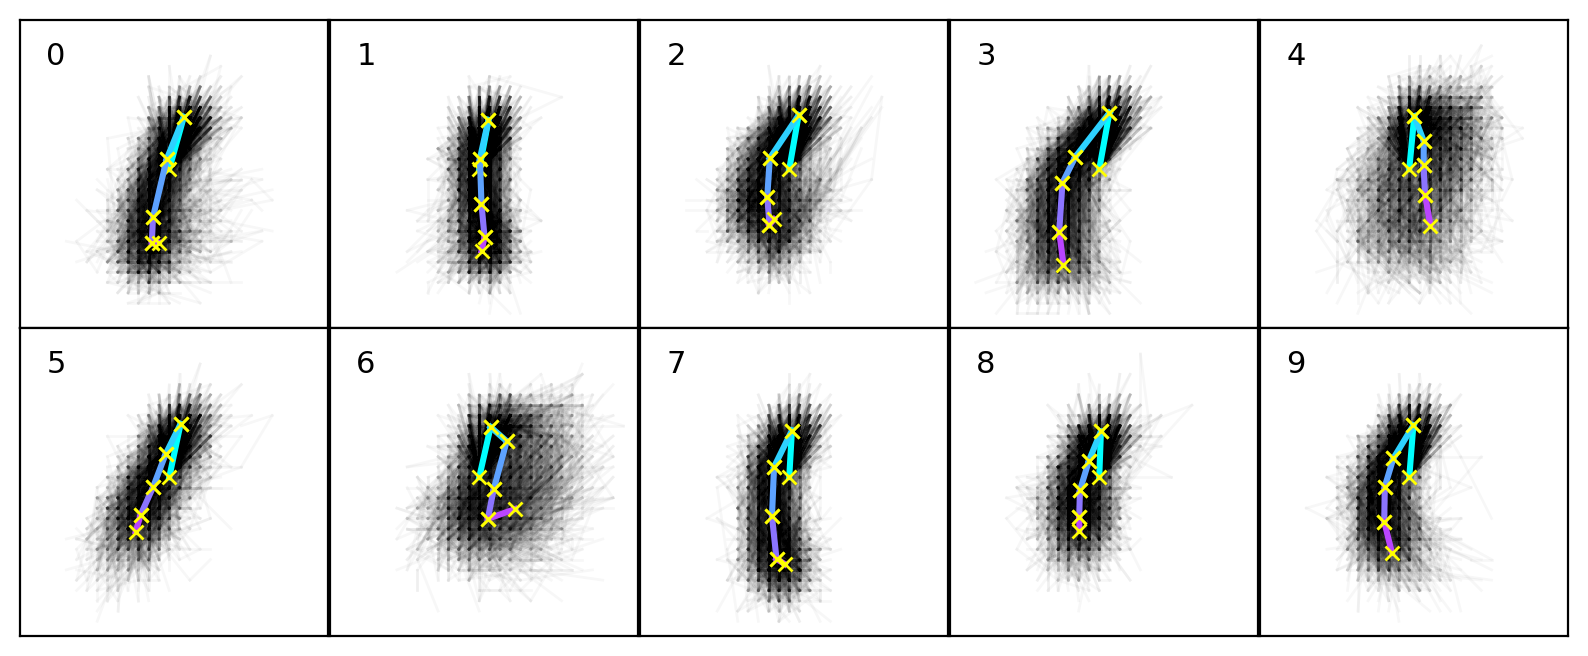

In [6]:
filename = os.path.join(plot_dir, model_name, 'mnist_trajectories3.pdf') # pdf

fig, axs = plt.subplots(2,5, figsize=(10,4), sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0})
axs = axs.ravel()
z = np.zeros((glimpses.shape[1], glimpses.shape[2]))
for c in range(10):
    inds = np.where(output[:, 0] == c)[0]
    ax = axs[c]
    ax.imshow(z, cmap='gray_r')
    xy = ls[:,inds] + g // 2 # centered on each glimpse

    for s in range(xy.shape[1]):
        for j, (start, stop) in enumerate(zip(xy[:-1,s], xy[1:,s])):
            x, y = zip(start, stop)
            ax.plot(x, y, '-', color='k', linewidth=1., alpha=0.03)

    xy = xy.mean(1)
    cmap=plt.cm.cool
    color = [cmap(i*2) for i in np.linspace(0, 1, xy.size)]
    for j, (start, stop) in enumerate(zip(xy[:-1], xy[1:])):
        x, y = zip(start, stop)
        ax.plot(x, y, 'x-', color=color[j],
                linewidth=2.2, markersize=5, mew=1, mec='yellow')
    ax.text(3,3, f'{c}', color='k', fontsize=11, ha='center', va='center')
    # if c != 0:
    #     ax.axis('off')
    # else:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# fig.tight_layout()

plt.savefig(filename, dpi=300, bbox_inches='tight')